In [29]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import desc
from pyspark.sql.functions import asc
from pyspark.sql.functions import sum as Fsum
from pyspark.sql import Window

import datetime

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

%matplotlib inline

Create Spark Session

In [3]:
#Note that Spark only allows one Spark context and one Spark session to be defined at any time.
#In the code below, 'GetOrCreate' will either create the Spark session or modify the existing one.

sparkSesh = SparkSession \
    .builder \
    .appName("app Name") \
    .config('config option','config value') \
    .master("local[*]") \
    .getOrCreate()

22/08/29 19:39:31 WARN Utils: Your hostname, rambino-AERO-15-XD resolves to a loopback address: 127.0.1.1; using 192.168.0.234 instead (on interface wlp48s0)
22/08/29 19:39:31 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/08/29 19:39:31 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Look at parameters of Spark context

In [6]:
sparkSesh.sparkContext.getConf().getAll()

[('spark.driver.host', '192.168.0.234'),
 ('spark.driver.extraJavaOptions',
  '-XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.cs=ALL-UNNAMED --add-opens=java.base/sun.security.action=ALL-UNNAMED --add-opens=java.base/sun.util.calendar=ALL-UNNAMED --add-opens=java.security.jgss/sun.security.krb5=ALL-UNNAMED'),
 ('config option', 'config value'),
 ('spark.executor.id', 'driver'),
 ('spark.sql.warehouse.dir',
  'file:/home/rambino/dev/DataEngineering_Udacity/05_Spark_DataLakes/spark-warehouse'),
 ('sp

Importing a basic file

In [46]:
read_path = "./sparkify_log_small.json"
log_data = sparkSesh.read.json(read_path)

Take a look at the data

In [7]:
#log_data.head()
#log_data.take(2)

#log_data.schema()
log_data.describe() #Similar to 'str' function (structure) in R for describing data frames

#log_data.count()

DataFrame[summary: string, artist: string, auth: string, firstName: string, gender: string, itemInSession: string, lastName: string, length: string, level: string, location: string, method: string, page: string, registration: string, sessionId: string, song: string, status: string, ts: string, userAgent: string, userId: string]

Drilling down into particular columns

In [ ]:
log_data.select("artist").show()
log_data.select("artist").dropDuplicates().sort('artist').show()

More advanced drilldown

In [11]:
# log_data \
#     .where(log_data.artist != "null") \
#     .groupBy('artist') \
#     .count() \
#     .orderBy('count', ascending=False) \
#     .show()


log_data \
    .select(["userId","page","song"]) \
    .where(log_data.userId == "1046") \
    .collect()

[Row(userId='1046', page='NextSong', song='Christmas Tears Will Fall'),
 Row(userId='1046', page='NextSong', song='Be Wary Of A Woman'),
 Row(userId='1046', page='NextSong', song='Public Enemy No.1'),
 Row(userId='1046', page='NextSong', song='Reign Of The Tyrants'),
 Row(userId='1046', page='NextSong', song='Father And Son'),
 Row(userId='1046', page='NextSong', song='No. 5'),
 Row(userId='1046', page='NextSong', song='Seventeen')]

Using custom function to create a new column in data frame

In [47]:
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(float(x) / 1000.0). hour)

#Note: this will not evaluate until data is called (lazy evaluation)
log_data = log_data.withColumn("hour", get_hour(log_data.ts))

Filtering sessions events by when users choose 'nextSong', and looking at the hour during which that happened.

In [38]:
song_hour_view = log_data \
    .filter(log_data.page == "NextSong") \
    .groupBy(log_data.hour) \
    .count() \
    .orderBy(log_data.hour.cast("float"))

song_hour_view.show()

+----+-----+
|hour|count|
+----+-----+
|   0|  147|
|   1|  225|
|   2|  216|
|   3|  179|
|   4|  141|
|   5|  151|
|   6|  113|
|   7|  180|
|   8|   93|
|  23|  205|
+----+-----+



Converting to Pandas data frame
>(Question: Why use pandas over spark?) Maybe to use matplotlib

In [20]:
pd_song_hour_view = song_hour_view.toPandas()

Text(0, 0.5, '# Songs played')

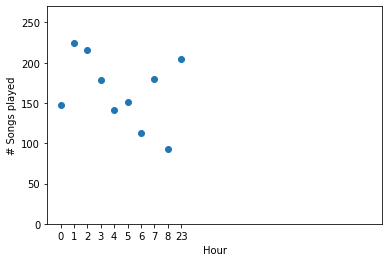

In [21]:
plt.scatter(pd_song_hour_view['hour'],pd_song_hour_view['count'])
plt.xlim(-1,24)
plt.ylim(0,1.2 * max(pd_song_hour_view['count']))
plt.xlabel("Hour")
plt.ylabel("# Songs played")

Data cleaning

In [48]:
#This will drop any records where 'userId' or 'sessionId' is missing
clean_log_data = log_data.dropna(how = "any", subset = ["userId","sessionId"])

#Clean out any fields where userId is an empty string
clean_log_data = clean_log_data.filter(clean_log_data["userId"] != "")

clean_log_data.count()

1925

### Additional Analysis: users who have upgraded their service
We'll take a look at the events before and after users decided to upgrade their subscriptions to try and find out why

In [49]:
#simple function for creating a column to flag downgrade events
flag_upgrade_event = udf(lambda x: 1 if x == "Submit Upgrade" else 0, IntegerType())

clean_log_data = clean_log_data.withColumn("upgrade", flag_upgrade_event("page"))
clean_log_data.head()

Row(artist='Showaddywaddy', auth='Logged In', firstName='Kenneth', gender='M', itemInSession=112, lastName='Matthews', length=232.93342, level='paid', location='Charlotte-Concord-Gastonia, NC-SC', method='PUT', page='NextSong', registration=1509380319284, sessionId=5132, song='Christmas Tears Will Fall', status=200, ts=1513720872284, userAgent='"Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='1046', hour='23', upgrade=0)

Definig a window function for partitioning data based on userId and ordering by time.

In [50]:
windowVal = Window \
    .partitionBy("userId") \
    .orderBy(desc('ts')) \
    .rangeBetween(Window.unboundedPreceding,0) #This including all PREVIOUS rows, but no rows after criteria.

clean_log_data = clean_log_data.withColumn("phase", Fsum("upgrade").over(windowVal))

Now, let's find a random customer who downgraded to try this on

In [51]:
clean_log_data \
    .select(['userId']) \
    .where(clean_log_data.page == "Submit Upgrade") \
    .show()

+------+
|userId|
+------+
|   512|
|  1232|
|  1079|
|   540|
+------+



In [52]:
clean_log_data \
    .select(['userId','firstname','ts','page','level','phase']) \
    .where(clean_log_data.userId == "1232") \
    .sort('ts') \
    .collect()

[Row(userId='1232', firstname='Dreden', ts=1513727268284, page='Home', level='free', phase=1),
 Row(userId='1232', firstname='Dreden', ts=1513727589284, page='NextSong', level='free', phase=1),
 Row(userId='1232', firstname='Dreden', ts=1513727885284, page='NextSong', level='free', phase=1),
 Row(userId='1232', firstname='Dreden', ts=1513728173284, page='NextSong', level='free', phase=1),
 Row(userId='1232', firstname='Dreden', ts=1513728346284, page='NextSong', level='free', phase=1),
 Row(userId='1232', firstname='Dreden', ts=1513728548284, page='NextSong', level='free', phase=1),
 Row(userId='1232', firstname='Dreden', ts=1513738827284, page='NextSong', level='free', phase=1),
 Row(userId='1232', firstname='Dreden', ts=1513739064284, page='NextSong', level='free', phase=1),
 Row(userId='1232', firstname='Dreden', ts=1513739103284, page='Upgrade', level='free', phase=1),
 Row(userId='1232', firstname='Dreden', ts=1513739104284, page='Submit Upgrade', level='free', phase=1),
 Row(user

Write data out

In [54]:
#This is cool - check out how Spark saves the file. For me, it's actually not a CSV at all, it's a FOLDER
#which has some metadata files and then multiple partitioned files. This is pretty cool - Spark is automatically
#partitioning my files, but keeping the abstraction very basic on my level.

from tkinter.filedialog import SaveAs


write_path = "./sparkify_log_small.csv"
clean_log_data.write.mode(saveMode="overwrite")
clean_log_data.write.save(write_path, format = "csv", header = True,)

ModuleNotFoundError: No module named 'tkinter'